# Exploring investment trends in the Israeli tech industry

In this notebook, we use data analysis and visualization techniques to gain insights into the investment trends within the tech sector. This analysis offers valuable perspectives for stakeholders, including investors, policymakers, and entrepreneurs, to understand the current landscape and identify areas for strategic intervention and support within the tech industry.

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype

import dash
from dash import dcc
from dash import html
import plotly.express as px
import plotly.graph_objs as go
from jupyter_dash import JupyterDash
from IPython.display import Image

In [2]:
df = pd.read_excel('../Insights_Challenge_Task_1.xlsx')
df[:5]

,name,founded_date,SUM_amount,exit_type,stage,employees,product_stage,geographical_markets,registrar_id,Primary_Sector_Name,NEWS_url,ANGELS_participated,tags
0,Fireblocks,2018,1039000000,NaN,C+,'201-500',Released,NaN,515863397.0,FinTech,https://www.calcalist.co.il/technology/article...,NaN,"otc, tokens, fintech, blockchain, unicorn_2021..."
1,DEEL,2018,679000000,NaN,C+,'500+',Released,Worldwide,515694370.0,"Enterprise, IT & Data Infrastructure",https://en.globes.co.il/en/article-payroll-co-...,1.0,"remote, fintech, payroll, payments, contracts,..."
2,Orca Security,2019,631500000,NaN,C+,'51-200',Released,Worldwide,515961761.0,Security Technologies,"https://www.calcalistech.com/ctech/articles/0,...",NaN,"aws, iaas, paas, saas, compliance, containers,..."
3,Wiz,2020,621000000,NaN,C+,'51-200',R&D,NaN,516146271.0,Security Technologies,https://www.globes.co.il/news/article.aspx?_at...,2.0,"containers, enterprises, unicorn_2021, cloud-s..."
4,Verbit,2017,532000000,NaN,C+,'500+',Released,Worldwide,515547735.0,"Enterprise, IT & Data Infrastructure","https://www.calcalistech.com/ctech/articles/0,...",NaN,"law, smb, saas, audio, video, hearing, academi..."


### Plot 1: Distribution of company stages

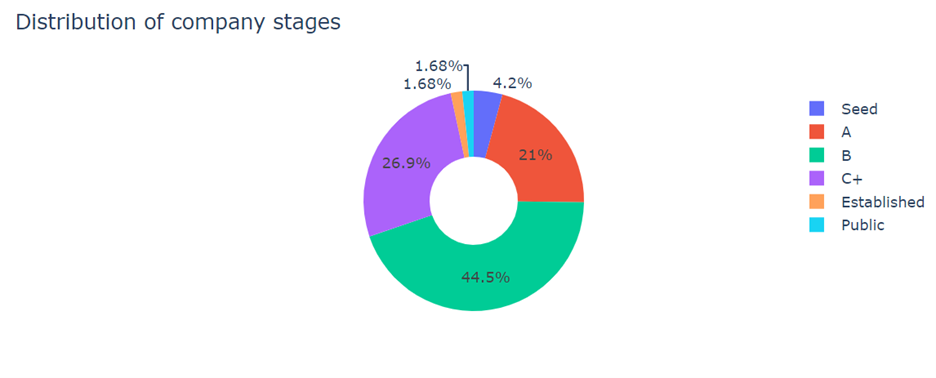

In [3]:
order = ["Seed", "A", "B", "C+", "Established", "Public"]
stage_counts = df['stage'].value_counts().loc[order]
fig1 = px.pie(values=stage_counts, names=stage_counts.index, title="Distribution of company stages", hole=0.4, category_orders={"names": order})
#fig1.show()
Image('fig1.png')

Here we see the proportion of startups at each stage and the overall maturity of the ecosystem. We see that the large part of startups has already developed its product and is starting to scale (B stage). The fact that there are more companies in the B stage than any other stage may suggest that the Israeli startup ecosystem is currently in a phase of growth and expansion. The relatively low percentage of companies in the Seed stage suggests that there may be a need for more early-stage funding and support. The low percentage of companies in the Established and Public stages suggests that there may be challenges in terms of scaling and going public for Israeli startups.

### Plot 2: Investment distribution by stage

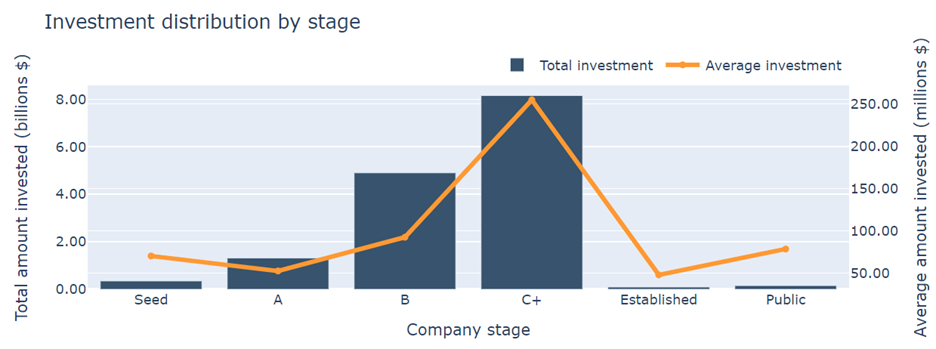

In [4]:
df_grouped = df.groupby('stage')['SUM_amount'].agg(['sum', 'mean']).loc[order].reset_index()

fig2 = go.Figure()

# Add the total investment
fig2.add_trace(go.Bar(
    x=df_grouped['stage'],
    y=df_grouped['sum']/ 1_000_000_000,
    name='Total investment',
    marker_color='rgb(55, 83, 109)'
))

# Add the average investment
fig2.add_trace(go.Scatter(
    x=df_grouped['stage'],
    y=df_grouped['mean']/ 1_000_000,
    name='Average investment',
    yaxis='y2',
    line=dict(color='rgb(255, 153, 51)', width=4)
))

fig2.update_layout(
    title='Investment distribution by stage',
    xaxis=dict(title='Company stage'),
    yaxis=dict(title='Total amount invested (billions $)', tickformat=',.2f'),
    yaxis2=dict(title='Average amount invested (millions $)',overlaying='y',side='right',tickformat=',.2f'),
    legend=dict(orientation='h',yanchor='bottom',y=1.02,xanchor='right',x=1)
)

#fig2.show()
Image('fig2.png')

Here we can identify which stages of startups are receiving the most investment and which stages may need more attention. We can see that the highest total investment amounts are in the C+ stage, followed by the B stage. This may indicate that investors are willing to commit larger amounts of capital to more mature startups with proven business models. It highlights the need to ensure that companies in earlier stages are able to access the capital they need to grow and succeed.

The plot also shows that as the stage of the company increases, the total amount invested in the company also tends to increase. This could suggest that companies that are able to grow through the stages are able to attract larger investments.

### Plot 3: Funding by company stage and sector

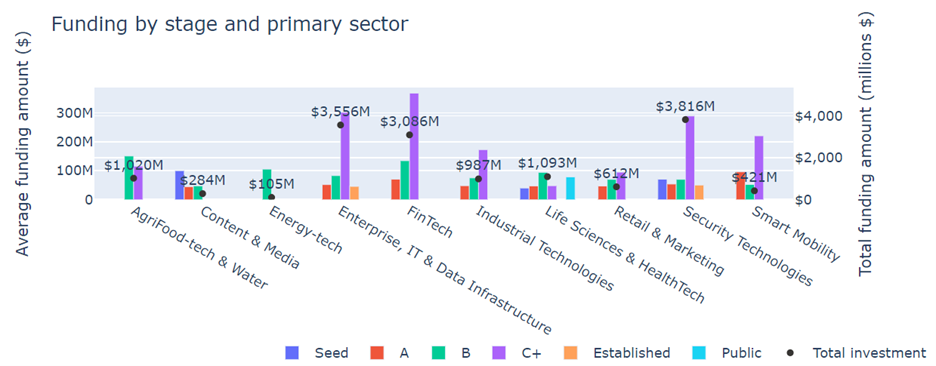

In [5]:
cat_type = CategoricalDtype(categories=order, ordered=True)
df['stage'] = df['stage'].astype(cat_type)

df_mean = df.groupby(['stage', 'Primary_Sector_Name'], as_index=False)['SUM_amount'].mean()

df_total = df.groupby(['Primary_Sector_Name'], as_index=False)['SUM_amount'].sum()
df_total['SUM_amount'] /= 1e6

fig3 = go.Figure()

for stage in df_mean['stage'].unique():
    df_stage = df_mean[df_mean['stage'] == stage]
    fig3.add_trace(go.Bar(x=df_stage['Primary_Sector_Name'], y=df_stage['SUM_amount'], name=stage))

fig3.add_trace(go.Scatter(
    x=df_total['Primary_Sector_Name'],
    y=df_total['SUM_amount'],
    name='Total investment',
    yaxis='y2',
    line=dict(color='rgb(55, 53, 51)', width=0),
    text=df_total['SUM_amount'].apply(lambda x: f"${x:,.0f}M"),
    textposition='top center',
    mode='markers+text',
))

fig3.update_layout(
    yaxis_title='Average funding amount ($)',
    yaxis2=dict(title='Total funding amount (millions $)',overlaying='y',side='right',
        tickformat='$,.0f',range=[0, df_total['SUM_amount'].max() * 1.4]),
    title='Funding by stage and primary sector',
    legend=dict(orientation='h',yanchor='top',y=-1.22,xanchor='right',x=1.2)
)

#fig3.show()
Image('fig3.png')

The plot provides insights into the funding trends in different sectors and stages of companies. It can help to identify which sectors and stages are receiving the most investment. Thus, we can provide more targeted resources and support to startups in the sectors and stage, such as mentorship programs, networking events, or funding opportunities.

### Plot 4: Number of companies by primary sector and year

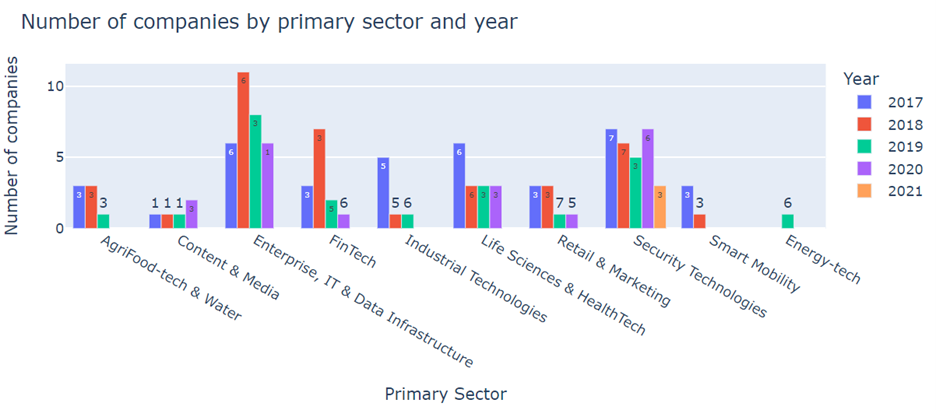

In [6]:
df['founded_date'] = df['founded_date'].astype(str)
df_count = df.groupby(['founded_date', 'Primary_Sector_Name'], as_index=False)['SUM_amount'].count()

fig4 = px.bar(df_count, x='Primary_Sector_Name', y='SUM_amount', color='founded_date', barmode='group',
             labels={'SUM_amount': 'Number of companies', 'Primary_Sector_Name': 'Primary sector'})

# Add text to the top of the bars
text_values = [f"{val:,.0f}" for val in df_count['SUM_amount']]
fig4.update_traces(text=text_values, textposition='auto')

fig4.update_layout(
    title='Number of companies by primary sector and year',
    xaxis_title='Primary Sector',
    yaxis_title='Number of companies',
    legend_title='Year',
)

#fig4.show()
Image('fig4.png')

The plot can help to identify sectors that may be growing (attracting more entrepreneurs) or declining, and potential gaps in the ecosystem that need to be addressed, such as a lack of support for startups in certain sectors or a need for more resources in certain areas.

Comparing to the last plot we can track which sectors are receiving the most investment and have the most growth potential. For example, the IT, FinTech and security sectors.

We can also identify potential collaboration opportunities between startups in complementary sectors. For example, there are many companies in IT & data infrastructure and many companies in smart mobility, so there may be potential for startups in these sectors to collaborate and develop solutions for the transportation industry. Similarly, with the FinTech and security technologies.

### Plot 5: Proportion of total investment in each product stage by primary sector

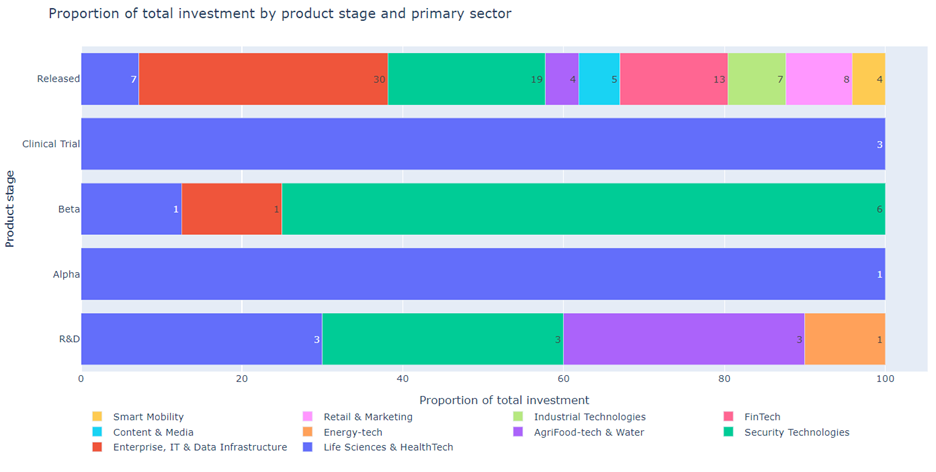

In [7]:
order = ["R&D", "Alpha", "Beta", "Clinical Trial", "Released"]
df_sector_investment = df.groupby(['product_stage', 'Primary_Sector_Name'])['SUM_amount'].count().reset_index()

df_stage_total = df.groupby(['product_stage'])['SUM_amount'].count().reset_index()
df_sector_investment['investment_proportion'] = df_sector_investment['SUM_amount'] / df_sector_investment.groupby('product_stage')['SUM_amount'].transform('sum') * 100

fig5 = go.Figure()

for sector in df_sector_investment['Primary_Sector_Name'].unique():
    df_sector = df_sector_investment[df_sector_investment['Primary_Sector_Name'] == sector]
    fig5.add_trace(go.Bar(
        x=df_sector['investment_proportion'],y=df_sector['product_stage'],
        name=sector,orientation='h',hovertemplate='%{x:.2f}%<br>%{y}<br>Total Investment: %{text:$,.0f}',
        text=df_sector['SUM_amount']
    ))

fig5.update_layout(
    title='Proportion of total investment by product stage and primary sector',
    xaxis=dict(tickformat='%{x:.0f}%',title='Proportion of total investment'),
    yaxis=dict(title='Product stage', categoryorder='array', categoryarray=order),
    legend=dict(orientation='h',yanchor='top',y=-0.15,xanchor='left',x=0),
    barmode='stack',bargap=0.2,margin=dict(l=0, r=0, t=70, b=0),height=600
)
#fig5.show()
Image('fig5.png')

The plot shows the proportion of total investment in different product stages for each primary sector. Many sectors get investment when they are in the 'released' product stage, with IT sector being the primary sector receiving more investment.

This plot helps us to focus on developing programs and initiatives that help R&D startups in the specific sectors  to receive more investment and grow, for example by attracting more investors in these sectors and developing strategies to promote investment in underrepresented sectors or product stages.

### Dashboard: Israeli innovation ecosystem analysis

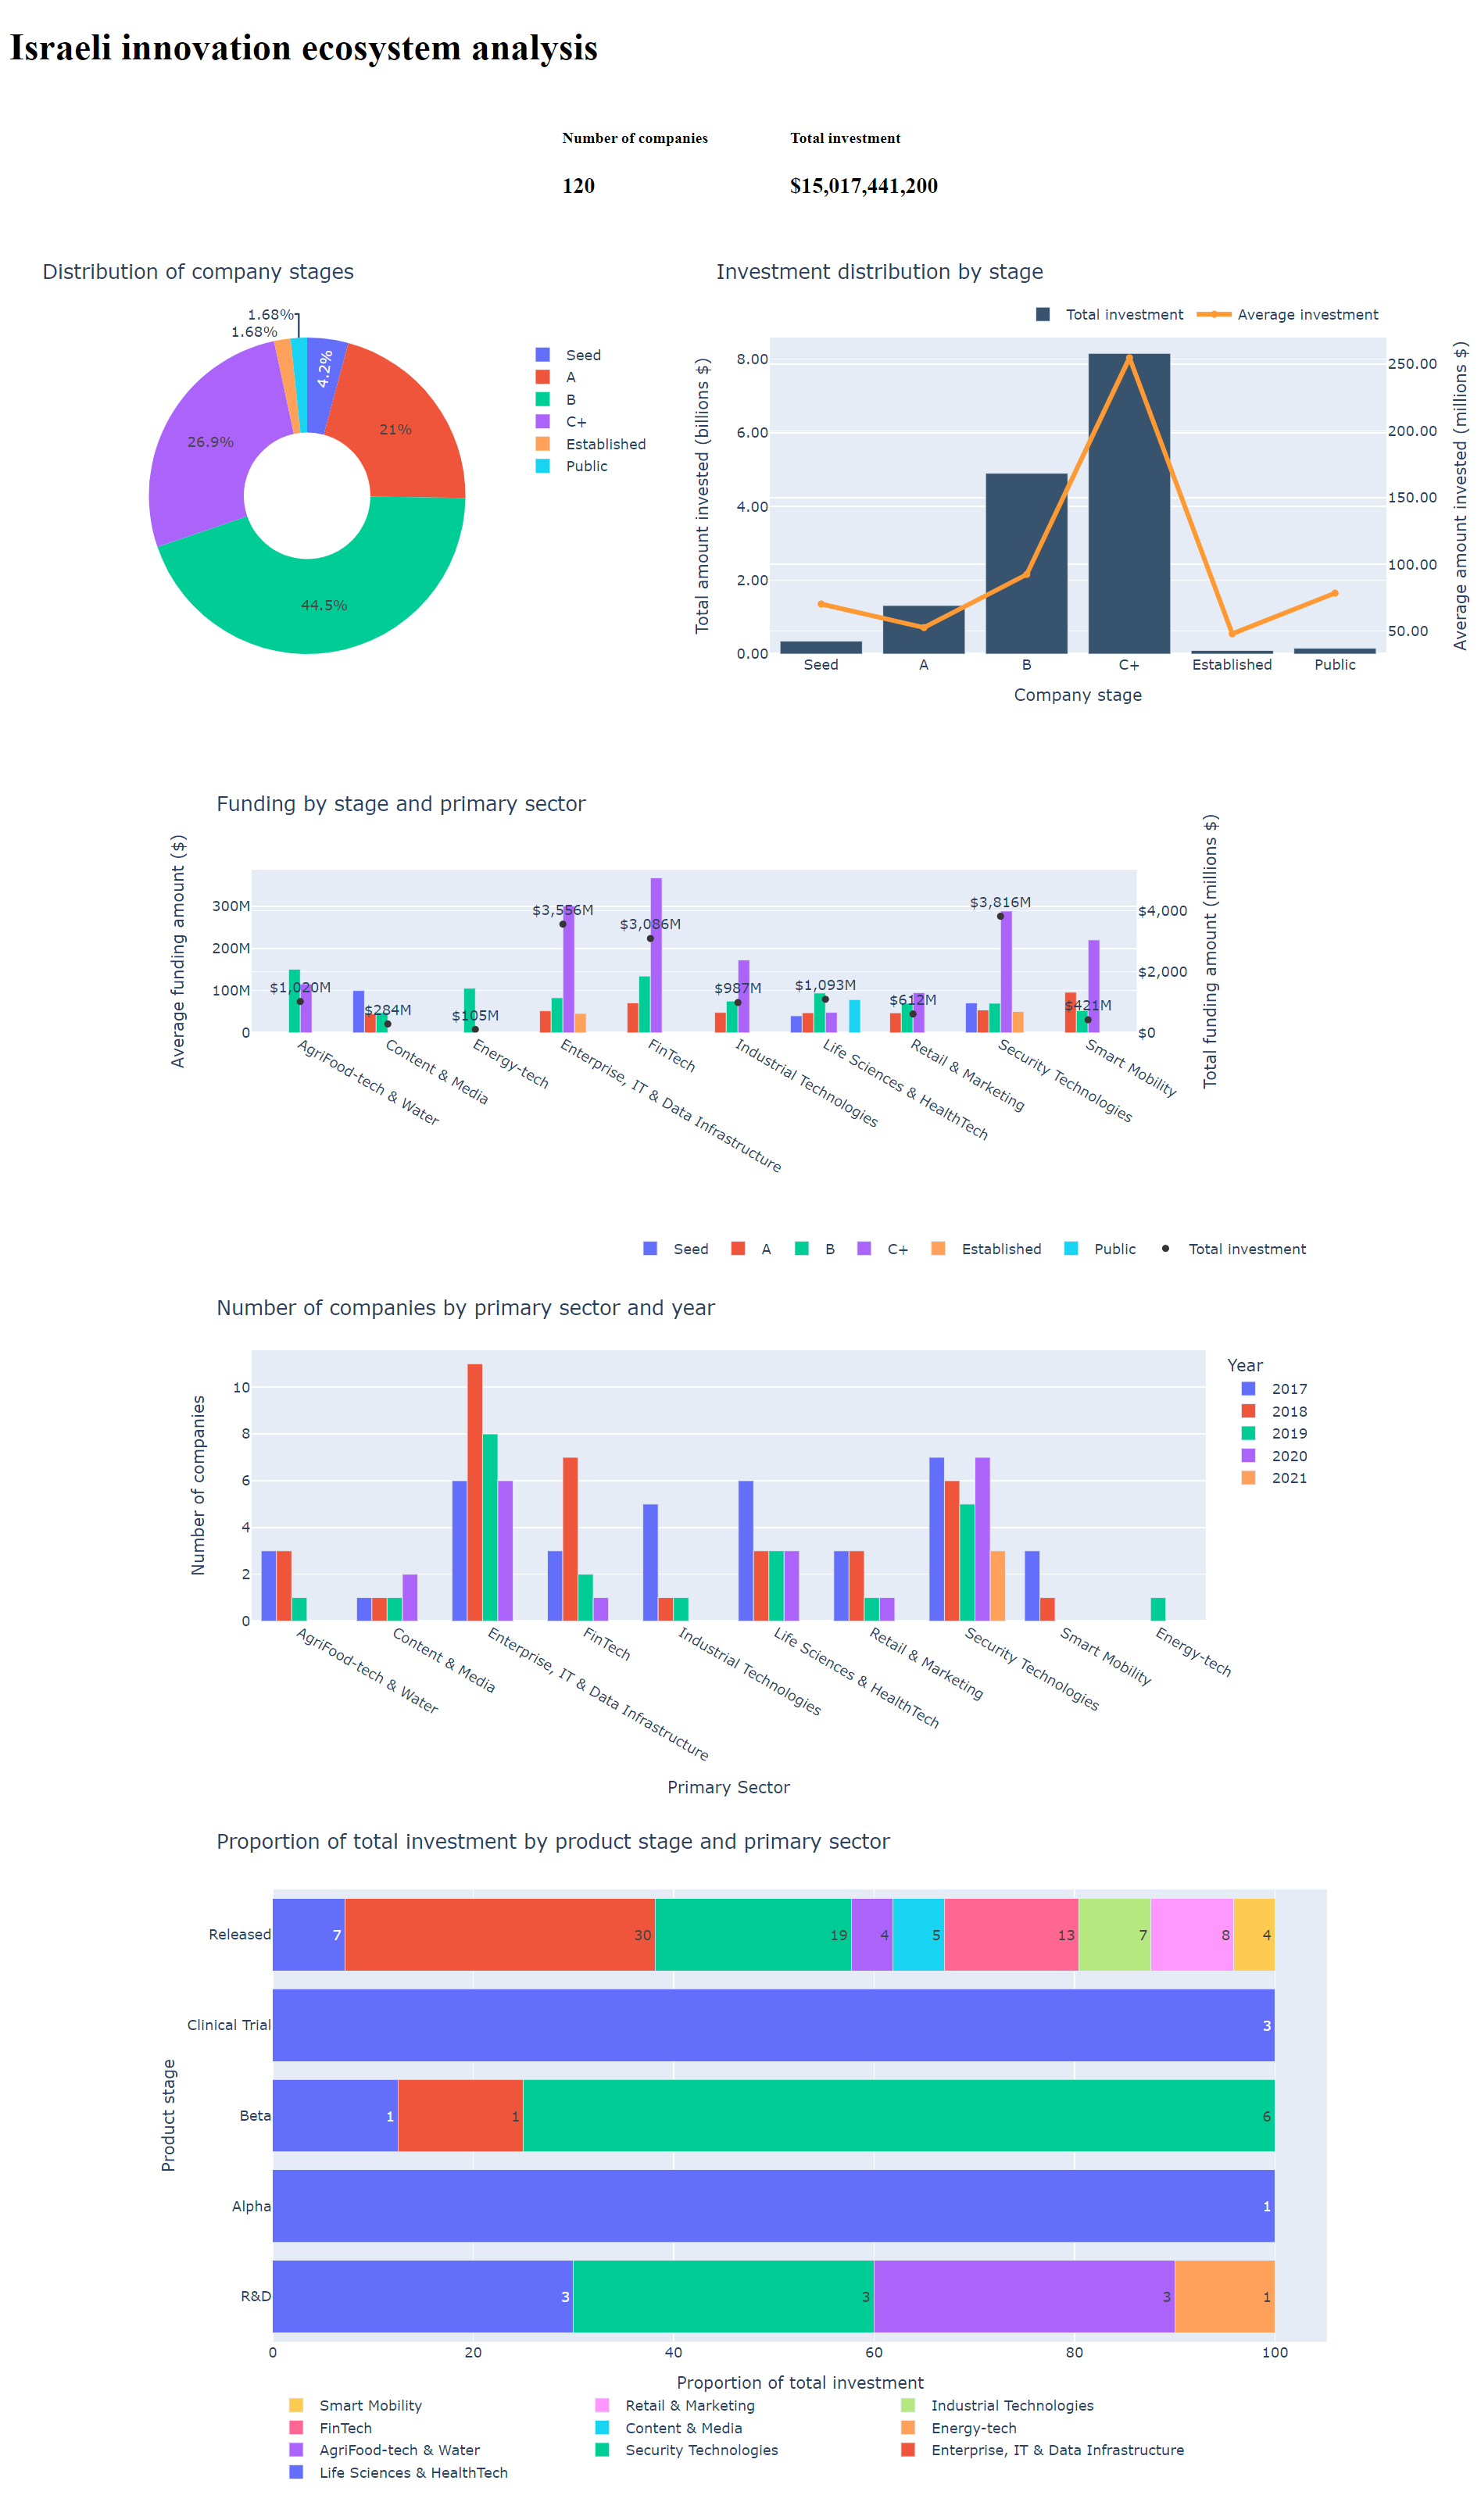

In [8]:
num_companies = len(df['name'].unique())
total_investment = df['SUM_amount'].sum()


app = JupyterDash(__name__)

app.layout = html.Div([
    html.H1('Israeli innovation ecosystem analysis'),
    
    html.Div([
        html.Div([
            html.H5('Number of companies'),
            html.H3(num_companies)
        ], className='indicator'),

        html.Div([
            html.H5('Total investment'),
            html.H3('${:,.0f}'.format(total_investment))
        ], className='indicator')
    ], className='indicators', style={'display': 'flex', 'justify-content': 'center', 'gap': '70px', 'margin-top': '30px'}),
    
    dcc.Graph(
        id='graph-1',
        figure=fig1,
        style={'width': '45%', 'display': 'inline-block'}
    ),
    
    dcc.Graph(
        id='graph-2',
        figure=fig2,
        style={'width': '55%', 'display': 'inline-block'}
    ),
    
    dcc.Graph(
        id='graph-3',
        figure=fig3,
        style={'width': '80%', 'margin': 'auto'}
    ),
    
    dcc.Graph(
        id='graph-4',
        figure=fig4,
        style={'width': '80%', 'margin': 'auto'}
    ),
    
    dcc.Graph(
        id='graph-5',
        figure=fig5,
        style={'width': '80%', 'margin': 'auto'}
    ),
])

#app.run_server(mode='inline')
Image('dash.png')